/Users/saul/p/lineapy/lineapy/db/relational/db.py:348: SAWarning: SELECT statement has a cartesian product between FROM element(s) "node" and FROM element "artifact".  Apply join condition(s) between each element to resolve.
  self.session.query(ArtifactORM)


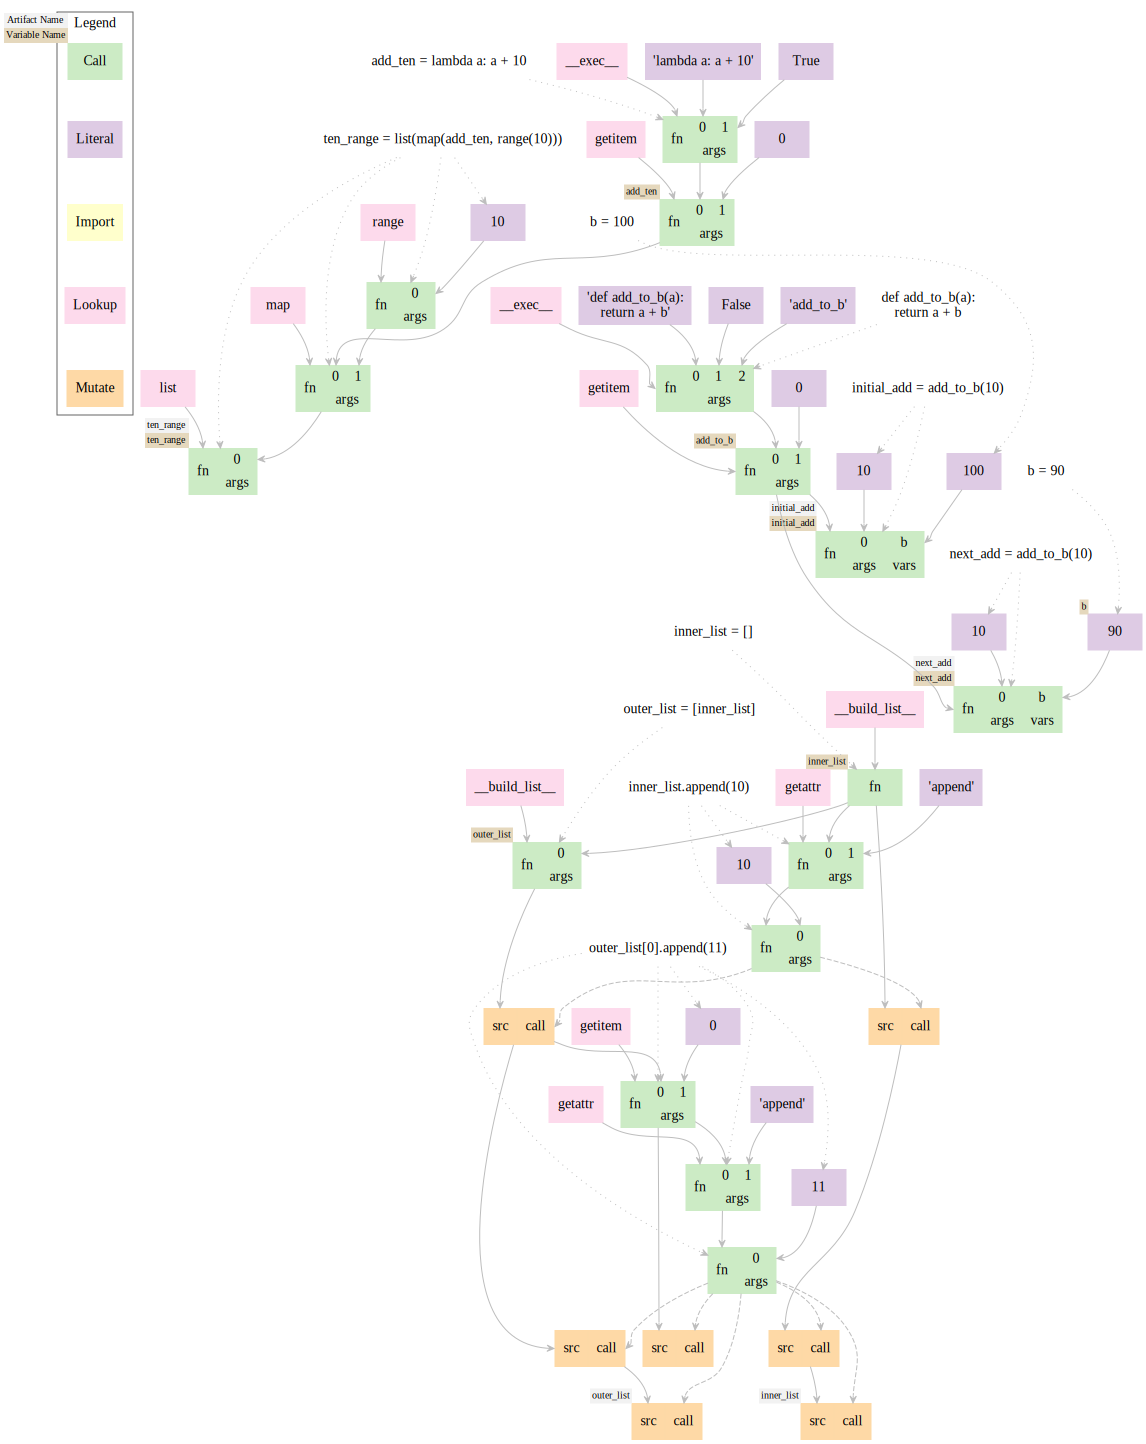

In [1]:
import lineapy
import lineapy.ipython
lineapy.ipython.start(visualize=True)

# Updates for the week of October 17th-22nd, 2021

Here is a list of what we have been up to this week!

## New Features

This week we continued add language support for functions and made our view/mutation tracking more robust.

### `lambda` support

We noticed that many data science notebooks use `lambda` functions, often as arguments to pandas calls, so we worked on adding support for them. The initial support landed in [#322](https://github.com/LineaLabs/lineapy/pull/322), by Shardul:

In [2]:
add_ten = lambda a: a + 10

ten_range = list(map(add_ten, range(10)))
lineapy.save(ten_range, "ten_range")
ten_range

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

### Function Late Binding

Then in [#329](https://github.com/LineaLabs/lineapy/pull/329) we added support for depending on global variables, and "late binding", a fun feature of Python where functions that use variables defined in the outer scope get them at call time and not creation time:

In [3]:
b = 100
def add_to_b(a):
    return a + b

initial_add = add_to_b(10)
lineapy.save(initial_add, "initial_add")
initial_add

110

In [4]:
b = 90
next_add = add_to_b(10)
lineapy.save(next_add, "next_add")
next_add

100

### View/Mutation Tracking

Last week we added initial support for tracking when a function mutates its arguments. For example, if you have a model in Scikit-Learn and you call `fit` on it, this will modify the model. Then if you call predict, the result of the prediction should depend on the `fit` call, which means tracking that `fit` mutated the model itself when it is called.

This week we made our view and mutation tracking more robust by treating all views as bidrectional. Let's start with a small example:

In [5]:
inner_list = []
outer_list = [inner_list]

Now we consider `inner_list` and `outer_list` to be "views" of one another. Which means that mutating one might mutate the other:

In [6]:
inner_list.append(10)
outer_list[0].append(11)

lineapy.save(inner_list, "inner_list")
lineapy.save(outer_list, "outer_list")

outer_list

[[10, 11]]

**Note that we have to manually instrument every built in and third party function to know what it mutates.** See the `inspect_function` in [`lineapy/instrumentation/inspect_function.py`](https://github.com/LineaLabs/lineapy/blob/main/lineapy/instrumentation/inspect_function.py) for a list of what we currently support.

### Slices

Currently we have to stop lineapy to extract out any slices. From creating this notebook, it seems like it would be much more natural to be able to see the slices as we continue tracking, so that might be a good item for next week!

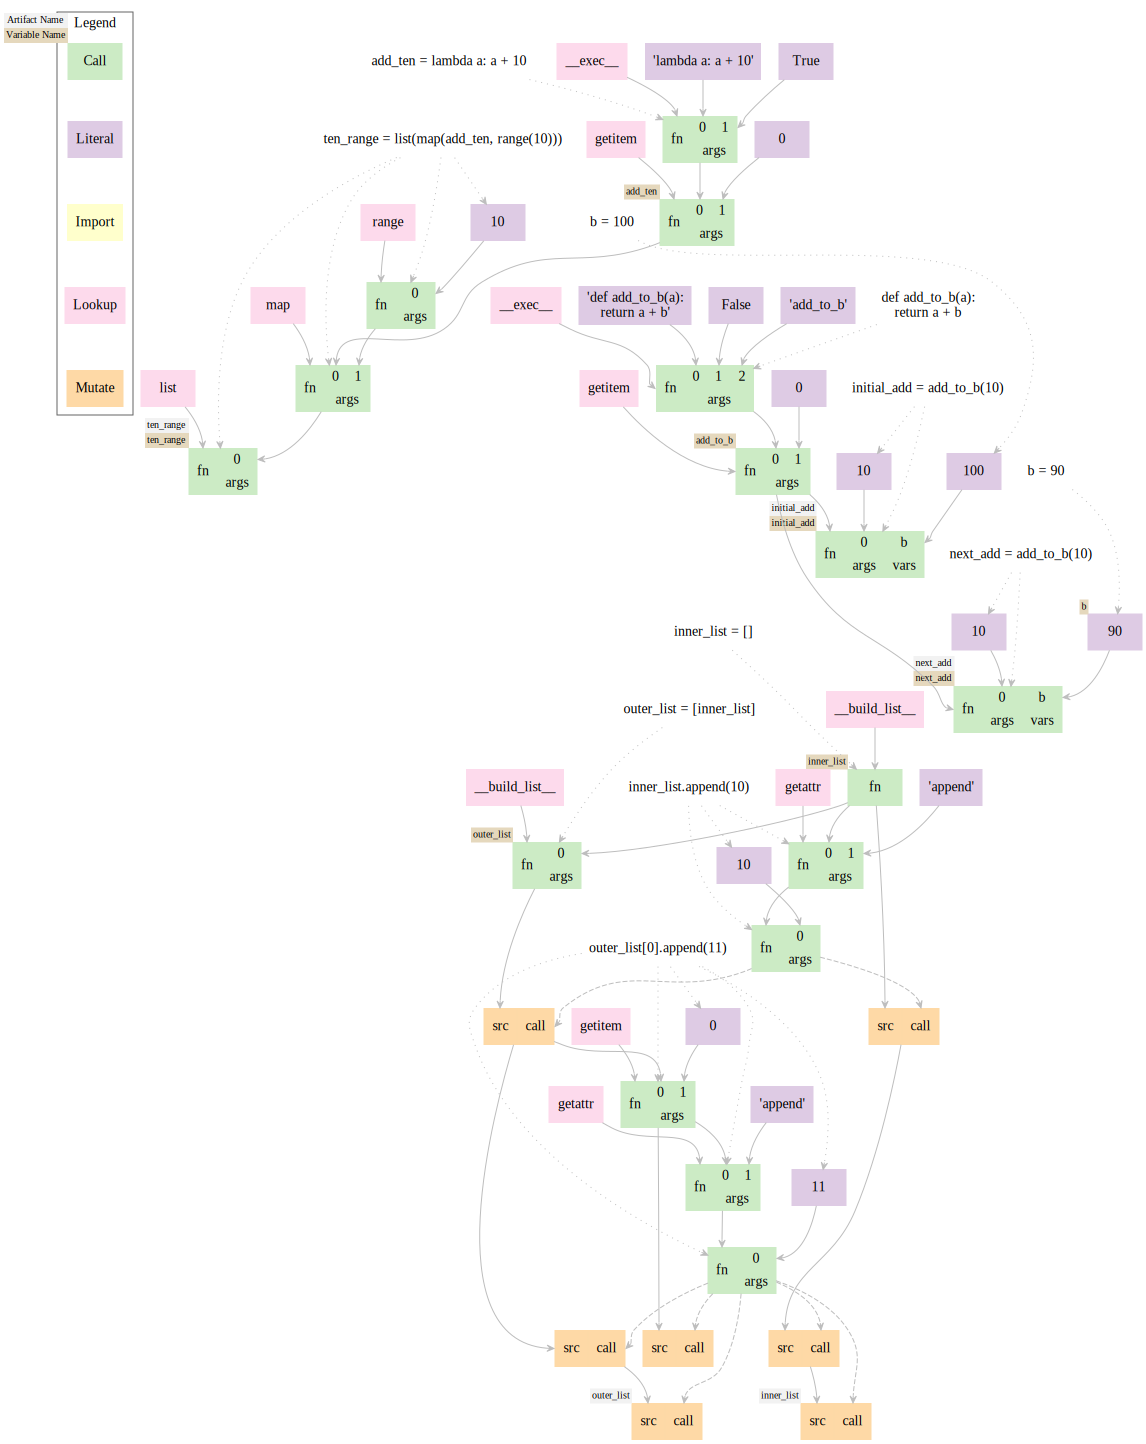

In [7]:
res = lineapy.ipython.stop()
res.graphviz()

#### `lambda` support

We can see that we capture lambda function and can slice with them:

In [8]:
print(res.slice('ten_range'))

add_ten = lambda a: a + 10
ten_range = list(map(add_ten, range(10)))



#### Function Late Binding

If we slice this on the first result, then we see it correctly depends on the first value of `b`.

In [9]:
print(res.slice('initial_add'))

b = 100
def add_to_b(a):
    return a + b
initial_add = add_to_b(10)



If we slice on the second, it sees that `b` has been rebound and picks up the second binding, seeing that the first is unnecessary. 

In [10]:
print(res.slice('next_add'))

def add_to_b(a):
    return a + b
b = 90
next_add = add_to_b(10)



#### View/Mutation Tracking

If we slice on either `inner_list` or `outer_list`, we can see that both mutations are included, since they are "views" of one another

In [11]:
print(res.slice('inner_list'))

inner_list = []
outer_list = [inner_list]
inner_list.append(10)
outer_list[0].append(11)



In [12]:
print(res.slice('outer_list'))

inner_list = []
outer_list = [inner_list]
inner_list.append(10)
outer_list[0].append(11)



## Continued Progress

### Airflow

We are moving towards having a working flow for producing Airflow jobs from Linea scripts [in #320](https://github.com/LineaLabs/lineapy/pull/320), which Mike is heading up thanks to his extensive Airflow experience!

### Multi Notebook Experience

We are also actively working on adding support for getting artifacts you have already saved, in order to fascilitate a multi notebook or script experience, where in one notebook you might do some data processing, and then pick up the results in the next notebook. Yifan has been working on that in [#297].(https://github.com/LineaLabs/lineapy/pull/297)

### Larger Test Notebook Corpus

We have been working on adding more notebooks so we can test Linea against them and see how it performs on real world use cases. Yifan added a few Kaggle noteboks in [#318](https://github.com/LineaLabs/lineapy/pull/318), which is what pushed us to add `lambda` support, and Shardul is working on adding a larger set of Kaggle notebooks to a seperate repo which we can use for testing.